# Embedding sparse word vectors into high-but-lower-dimensional dense space

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/playdl/blob/master/mnist/notebooks/word-embeddings.ipynb)

Word vectors are simple but the vocabulary size can make word vectors extremely long; high dimensionality. And they are very sparse, mostly zeros.

Word embeddings, on the other hand, embed that massive dimensional space into a smaller, dense space. For example, [GloVE](https://nlp.stanford.edu/projects/glove/) has pre-trained word embeddings of various sizes such as 50 and 300 dimensions. Unlike word vectors, we need to do some training to compute embeddings. I've used pre-trained word-to-embedding dictionaries to good effect, but we can also train and embedding specific to our task as part of our model, using an embedding layer.

## Getting random but dense not sparse word vectors

In [word-vectors](word-vectors.ipynb), we created sparse vectors representing words. When added together, these create bag of words (BOW) representations of documents. We can just turn on the particular position of a word in the vector if that word is present in the document. 

If we are passing words individually to a recurrent neural network (RNN), then these sparse vectors can get pretty big. If there are 20,000 words in the dictionary, we might have vectors of size 20,000. What we need is a dense representation that still gives us unique representations of each word.  (We also used to the hash trick also to try to shrink the size of the sparse vectors, but they are still sparse.)

In [1]:
import numpy as np
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
# sample tweets from my twitter inbox with added text for experimentation
samples = [
    """Tesla Motors has nothing to do with this tweet.
    On those rare occasions when I really, really need to reduce the
    size of a file I use "xz -9". Today I found out about the "extreme" setting
    and "xz -e9" squeezed files down another 15% or so. It is not exactly quick,
    but that doesn't really matter in such cases!""",
    
    """Securities and exchange commission has nothing to do with this tweet.
    Do grad students get paid a lot? No. But do we at least have solid
    job security? Also, no. But are we at least ensured a stress-free work
    environment with a healthy work-life balance? Still, also no.""",

    """A design process hyperfocused on A/B testing can result in dark patterns even
    if that’s not the intent. That’s because most A/B tests are based on metrics
    that are relevant to the company’s bottom line, even if they result in harm to users."""
]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(samples)
words = tokenizer.word_index.keys() # get tokenized words

If we are not using a hash function but instead dense factors, we need a dictionary to keep track of the word to vector mapping. But, we can create vectors of any length and get very little chance of collision. For example, even with a single floating-point number between 0 and 1, with our 96 words in the vocabulary, there's almost no chance of collision

In [3]:
def hashwords(words, dimensionality = 4):
    return {w:np.random.random(size=dimensionality) for w in words}

In [4]:
index = hashwords(words, dimensionality=4)
list(index.items())[:10]

[('a', array([0.74813393, 0.15237295, 0.95414246, 0.6658087 ])),
 ('to', array([0.76290396, 0.64180381, 0.53569385, 0.16594362])),
 ('do', array([0.66534492, 0.39515198, 0.54270866, 0.48688513])),
 ('the', array([0.86020141, 0.53697074, 0.45104853, 0.5343488 ])),
 ('with', array([0.85016867, 0.86766001, 0.18249972, 0.88276414])),
 ('on', array([0.51417153, 0.129233  , 0.89874536, 0.48375021])),
 ('i', array([0.52733252, 0.68938374, 0.42720063, 0.39019705])),
 ('really', array([0.5014101 , 0.75332849, 0.88166986, 0.98835455])),
 ('but', array([0.41445748, 0.46236684, 0.27051044, 0.7635591 ])),
 ('in', array([0.3168832 , 0.20908108, 0.97965266, 0.27142978]))]

In [5]:
ncollisions = len(index) - len(set([tuple(a) for a in index.values()]))
print(f"There were {ncollisions} collisions between dense word vectors")

There were 0 collisions between dense word vectors


Note that if we only use dimensionality=1, then we are right back to label encoding, just with a floating-point number instead of an integer. We need at least a dimensionality of two.

What happens if we need to send an entire document not just a single word into a model? We need a continuous bag of words (CBOW), which is easy for one hot encoding.  We just turn on all relevant word-columns. For dense vectors, we either need to concatenate them together or sum or average them into a single vector. If documents are different length, then concatenating them doesn't work because models typically require fixed length input.

## Word embeddings

Those vectors are dense but there is literally no meaning to the values in the vector positions. Two similar words are in no way similar in some kind of semantic space. We are not helping the model very much. 

The key idea for improvement is "*You shall know a word by the company it keeps.*" ([John Firth](https://en.wikipedia.org/wiki/John_Rupert_Firth), 1957).  Here is a [nice paper on GloVe](https://nlp.stanford.edu/pubs/glove.pdf).  I think this was the [word2vec paper that got word vectors started](https://arxiv.org/pdf/1301.3781.pdf).

BTW, this also works for embedding of other things like movies/users (from the netflix challenge) and [airlines](https://djcordhose.github.io/ml-workshop/2019-embeddings.html). If we want to get dense vectors for airline names, we need some mechanism to indicate similarity between airlines so that, rather than random dense factors, we can get dense vectors where airlines are somehow close to each other in some appropriate dense space.

### skip-gram

If we see the word `New`, very likely `York` will follow. If we see the word `bear`, it's likely that `brown`, `black`, or `grizzly` would proceed `bear`. The words `network` is unlikely to precede or follow `bear` in close proximity. We can train a neural network to respond to a word with word probabilities that could occur in a neighborhood, before or after.

The training for the network is x = one-hot word vector for a single word and y = vector of probabilities of appearing in the neighborhood for all words. If there are 1000 words in our vocabulary then each x and y will be vectors of length 1000.

### CBOW

Or, we can train a CBOW representation of the neighborhood (a few words on either side) to recognize the center word.

In either case, the weights of the single hidden layer represent the word embeddings.

In either case, we are using a sliding window that moves over the words in a document. Global information about co-occurrence of words is not used.  Apparently a huge amount of data is required to avoid overfitting and training is expensive, given the explosion of training samples.

### GloVe

The [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) approach uses a word co-occurrence matrix and I think is a little easier to understand.  If there are 1000 words in the vocabulary, then the co-occurrence matrix is 1000 x 1000. The entry at i,j is how often words i and j co-occur in the corpus. They have a more complicated model to solve I think than word2vec, but creating the cooccurrence matrix seems easier and smaller than the sliding window training set.

## Homebrew embeddings

The [fastai book chapter 8](https://github.com/fastai/fastbook/blob/master/08_collab.ipynb) has an example using user-movie-ratings from [MovieLens](https://grouplens.org/datasets/movielens/).  I will grab [a small subset](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) and put into `data` subdir:

```
data/ml-latest-small
├── README.txt
├── links.csv
├── movies.csv
├── ratings.csv
└── tags.csv
```

"*Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).*" The `ratings.csv` file looks like:

```
userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
...
```

And, in case we are curious, `movies.csv` has:

```
movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
...
```

Though I think the task will be simply to match up userId and movieId to create an embedding. There are about 100,000 entries in this small set, but we can grab a tiny subset of those just to see what we are dealing with at first.

In [6]:
import pandas as pd
np.set_printoptions(precision=2, suppress=True, linewidth=3000, threshold=20000)

def load(n = 10):
    df_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')
    df_ratings = df_ratings.drop('timestamp', axis=1)
    df_ratings = df_ratings.sample(n=n).reset_index(drop=True)
    return df_ratings

df_ratings = load(n=10)
df_ratings.head(5)

,userId,movieId,rating
0,325,296,5.0
1,492,761,4.0
2,391,1748,5.0
3,357,4069,2.0
4,57,2028,5.0


Rather than deal with arbitrarily large integers representing the various IDs, let's compress that down to unique but adjacent integers.

In [7]:
catencoders = {}
def compress_cats(df, colname):
    df[colname] = df[colname].astype('category').cat.as_ordered()
    catencoders[colname] = df[colname].cat.categories
    df[colname] = df[colname].cat.codes + 1
    
compress_cats(df_ratings, "userId")
compress_cats(df_ratings, "movieId")
df_ratings.head(5)

,userId,movieId,rating
0,5,2,5.0
1,9,4,4.0
2,8,6,5.0
3,7,9,2.0
4,2,7,5.0


In [8]:
nusers = len(df_ratings.groupby('userId').count())
nmovies = len(df_ratings.groupby('movieId').count())
(nusers,nmovies)

(10, 10)

### Map movie to user

Let's try mapping users to movies with a neural network. Presumably people self filter the movies they watch and so there could be information that will tell us about users and/or movies.

In [37]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras.datasets import mnist
from tensorflow.keras import models, layers, callbacks, optimizers
import tqdm
from tqdm.keras import TqdmCallback
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

In [38]:
df_ratings = load(n=10000)
compress_cats(df_ratings, "userId")
compress_cats(df_ratings, "movieId")
nusers = len(df_ratings.groupby('userId').count())
nmovies = len(df_ratings.groupby('movieId').count())
n = len(df_ratings)
n, nusers, nmovies

(10000, 596, 3638)

In [39]:
X = pd.get_dummies(df_ratings['movieId'])
y = df_ratings['userId'] #pd.get_dummies(df_ratings['userId'])
X.shape, y.shape

((10000, 3638), (10000,))

In [40]:
X.head(3)

,1,2,3,4,5,6,7,8,9,10,...,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
y.head(3)

0    367
1    304
2    576
Name: userId, dtype: int16

In [140]:
layer1 = 20
layer2 = 200
batch_size = 50
model = models.Sequential()
model.add(layers.Dense(layer1, name='embedding', input_dim=nmovies, activation='relu')) # input_shape=(n,nmovies)
model.add(layers.Dense(layer2, activation='relu'))
model.add(layers.Dense(nusers+1, activation='softmax'))

opt = optimizers.RMSprop()

model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
#model.summary()


Keras validation accuracy 0.3346


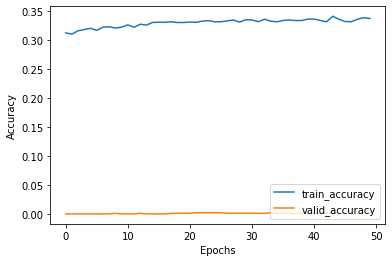

In [142]:
history = model.fit(X, y,
                    shuffle=True,
                    epochs=50,
                    validation_split=0.10,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

y_pred = model.predict(X.values.reshape(-1,nmovies))
y_pred = np.argmax(y_pred, axis=1)
val_accur = accuracy_score(y, y_pred)
print("Keras validation accuracy", val_accur)

import matplotlib.pyplot as plt

plt.ylabel("Accuracy")
plt.xlabel("Epochs")

accur = history.history['accuracy']
plt.plot(accur, label='train_accuracy')
val_accur = history.history['val_accuracy']
plt.plot(val_accur, label='valid_accuracy')
# plt.xlim(0, 200)
# plt.ylim(0.5, 1.02)
plt.legend(loc='lower right')
plt.show()

Validation error is terrible, but [Oliver](http://www.zeigermann.eu/) says we care about training error for getting embeddings since we won't be using the predictions.  In his example, he only has about 10% accuracy so I'm going to consider roughly 30% quite good. :)

[Here](https://djcordhose.github.io/ml-workshop/2019-embeddings.html#/17), Oliver explains how to get the embeddings out. These are the outputs from the first constrained layer.

In [155]:
embedding_layer = model.get_layer('embedding')
w, b = embedding_layer.get_weights()
w.shape
w

array([[-0.19, -0.18, -0.17, ...,  0.21, -0.18,  0.09],
       [-0.09,  0.3 , -0.05, ...,  0.14,  0.05, -0.1 ],
       [-0.11,  0.17, -0.11, ..., -0.07,  0.28,  0.03],
       ...,
       [ 0.03, -0.03,  0.03, ...,  0.01, -0.03, -0.02],
       [-0.05,  0.17, -0.17, ..., -0.17, -0.25,  0.14],
       [-0.02,  0.19, -0.13, ..., -0.17, -0.25,  0.14]], dtype=float32)

In [202]:
uniq_movieIds = np.unique(df_ratings['movieId'])
uniq_movieIds = pd.get_dummies(uniq_movieIds)
uniq_movieIds

,1,2,3,4,5,6,7,8,9,10,...,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [204]:
uniq_movieIds.shape, w.shape, b.shape

((3638, 3638), (3638, 20), (20,))

The shape of the weight matrix is the transpose of what I would expect. For example, I like the convention of a row being the weights of a single neuron. Since I have 20 neurons, I would expect 20 rows, but still we can just reverse the operators of the dot product. The following should give us the output of the embedding layer:  take the dot product of every input movie one-hot and multiply times the weight vector then add the bias. Note: The dot product is really just selecting the ith row of w for one-hot turned on at position i.  A row in w is the set of weights across neurons for a particular feature, a word in our case. That gives us a vector in 20-space where each dimension is some semantic meaning we got from a neuron.

In [205]:
movie_embeddings = np.dot(uniq_movieIds, w) + b
print(movie_embeddings.shape)
movie_embeddings

(3638, 20)


array([[-0.01,  0.13,  0.07, ...,  0.38,  0.17,  0.22],
       [ 0.09,  0.6 ,  0.19, ...,  0.31,  0.4 ,  0.03],
       [ 0.08,  0.47,  0.13, ...,  0.1 ,  0.63,  0.17],
       ...,
       [ 0.21,  0.28,  0.27, ...,  0.18,  0.32,  0.12],
       [ 0.13,  0.48,  0.07, ..., -0.  ,  0.1 ,  0.27],
       [ 0.16,  0.49,  0.11, ..., -0.  ,  0.1 ,  0.27]], dtype=float32)

In [207]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')
df_movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [208]:
df_ratings.merge(df_movies, on='movieId')

,userId,movieId,rating,title,genres
0,367,2111,4.5,"Man with Two Brains, The (1983)",Comedy
1,377,2111,3.5,"Man with Two Brains, The (1983)",Comedy
2,304,144,4.0,"Brothers McMullen, The (1995)",Comedy
3,105,144,3.0,"Brothers McMullen, The (1995)",Comedy
4,340,144,3.0,"Brothers McMullen, The (1995)",Comedy
...,...,...,...,...,...
7421,357,731,4.0,Heaven's Prisoners (1996),Crime|Thriller
7422,463,2116,4.0,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
7423,180,778,3.0,Trainspotting (1996),Comedy|Crime|Drama
7424,582,2696,4.0,"Dinner Game, The (Dîner de cons, Le) (1998)",Comedy


### Movie+user -> rating

Ok, Let's try to map both the movie and the user to a rating.

In [28]:
df_ratings = load(n=10000)
compress_cats(df_ratings, "userId")
compress_cats(df_ratings, "movieId")
nusers = len(df_ratings.groupby('userId').count())
nmovies = len(df_ratings.groupby('movieId').count())
n = len(df_ratings)
n, nusers, nmovies

(10000, 600, 3624)

In [29]:
X = pd.concat([pd.get_dummies(df_ratings['movieId']),
               pd.get_dummies(df_ratings['userId'])], axis=1)
y = df_ratings['rating'] #pd.get_dummies(df_ratings['userId'])
X.shape, y.shape

((10000, 4224), (10000,))

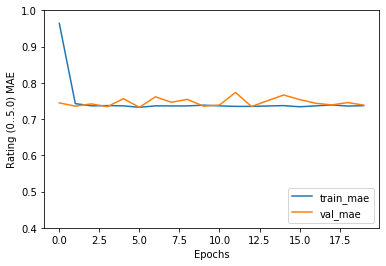

In [33]:
layer1 = 10
layer2 = 100
batch_size = 10
model = models.Sequential()
model.add(layers.Dense(layer1, input_dim=nmovies+nusers, activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(0.00001))) # input_shape=(n,nmovies)

model.add(layers.Dense(layer2, activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(0.00001)))
#model.add(layers.BatchNormalization())
#model.add(layers.Dropout(0.5))

model.add(layers.Dense(1))

opt = optimizers.RMSprop()

model.compile(loss='mean_squared_error',
              optimizer=opt,
              metrics=['mae'])
#model.summary()

history = model.fit(X, y,
                    shuffle=True,
                    epochs=20,
                    validation_split=0.15,
                    batch_size=batch_size,
                    verbose=0,
                    callbacks=[tfa.callbacks.TQDMProgressBar(show_epoch_progress=False)]
                    )

plt.ylabel("Rating (0..5.0) MAE")
plt.xlabel("Epochs")
accur = history.history['mae']
plt.plot(accur, label='train_mae')
val_accur = history.history['val_mae']
plt.plot(val_accur, label='val_mae')
# plt.xlim(0, 200)
plt.ylim(0.4, 1.00)
plt.legend(loc='lower right')
plt.show()

## Collaborative filtering

Now, let's create a matrix that maps user and movie to a rating. Most of the entries will be zero because not all users have seen all movies.

In [ ]:
ratings = np.zeros(shape=(nusers+1,nmovies+1))
for u,m,r in df_ratings.values:
    ratings[int(u),int(m)] = r
ratings

Download and uncompress [movie review polarity data set v2.0](https://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz) and put into `data` subdir.  The files contain positive and negative reviews:

```
data/review_polarity/txt_sentoken/
├── neg
│   ├── cv000_29416.txt
│   ├── cv001_19502.txt
│   ├── cv002_17424.txt
...
└── pos
    ├── cv000_29590.txt
    ├── cv001_18431.txt
    ├── cv002_15918.txt
    ├── cv003_11664.txt
...
```

The idea will be to map